In [3]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema

plt.rcParams["figure.figsize"]=10,3
text_size = 20
plt.rc('xtick', labelsize=text_size) 
plt.rc('ytick', labelsize=text_size) 
line_width = 2.5
plt.style.use('ggplot')
sns.set_palette("twilight")

In [24]:
def get_number_string(string):
    import re
    s = [float(s) for s in re.findall(r'-?\d+\.?\d*', string)]
    return s[0]

def read_xvg(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            try:
                x1 = float(line.split()[0])
                y1 = float(line.split()[1])
                x.append(x1)
                y.append(y1)
            except ValueError:
                pass
    return x, y

def get_df(to_read):
    # define locations of files
    k_310_2 =  '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations/310K/2'
    k_310_1 = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations/310K/1'
    k_400 = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations/400K'
    base = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations'
    # read data
    os.chdir(k_310_1)
    x_310_1, y_310_1 = read_xvg(to_read)

    os.chdir(k_310_2)
    x_310_2, y_310_2 = read_xvg(to_read)

    os.chdir(k_400)
    x_400, y_400 = read_xvg(to_read)
    # create data frame and melt
    df_dict = {"x": x_310_1,
          "310K - 1" : y_310_1,
          "310K - 2" : y_310_2,
          "400K" : y_400}

    df = pd.DataFrame(df_dict)
    df = pd.melt(df, id_vars=['x'], value_vars=['310K - 1', '310K - 2', '400K'])
    df.columns = ['Time', 'Simulation', 'value']
    os.chdir(base)
    return df

def plot_joint(data, text_size = 15, xlabel = "Time (ps)", ylabel = "RMSD (nm)"):
    """
    plots a joint plot of selected dataframe
    """
    plt.style.use('ggplot')
    sns.set_palette("twilight")
    plt.rc('xtick', labelsize=text_size) 
    plt.rc('ytick', labelsize=text_size) 

    f, axs = plt.subplots(1,2,
                      figsize=(10,3),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[3,0.5]))

    sns.lineplot(data = data,
                x = "Time",
                y = "value",
                hue = "Simulation",
                ax = axs[0])


    sns.kdeplot(data = data,
                y = "value",
                hue = "Simulation",
                legend = False,
                ax = axs[1])
    axs[0].set_xlabel(xlabel, size = text_size) 
    axs[0].set_ylabel(ylabel, size = text_size)
    axs[1].set_xlabel("", size = text_size) 
    axs[1].axes.get_xaxis().set_visible(False)
    axs[0].legend(title = "Simulation", fontsize=text_size, title_fontsize=text_size)

    f.tight_layout()
    
def get_mean(df):
    """
    returns mean values from the simulations data frame
    """
    return df.groupby("Simulation")["value"].mean()

def plot_fes(number, text_size = 15, xlabel = "CV (nm)", ylabel = "Bias potential (kj/mol)", with_minima = False, sizex = 6, sizey = 3):
    """ 
    number - metadynamics simulation number
    with_minima - (not)plot the minima points for the last set in metadynamics simulation
    """
    plt.rcParams["figure.figsize"]= sizex, sizey
    plt.rc('xtick', labelsize=text_size) 
    plt.rc('ytick', labelsize=text_size) 
    base = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations'
    plot = str(number)
    os.chdir(base + "/Metadynamics/" + plot + "/fes_data")
    file_list = os.listdir()
    df_full = pd.DataFrame()
    for file in file_list:
        if "fes" in file:
            number = get_number_string(file)
            x, y = read_xvg(file)
            df_dict = {"Step" : number,
                      "x": x,
                      "y": y}
            df = pd.DataFrame(df_dict)
            df_full = df_full.append(df)
    sns.lineplot(data = df_full,
            x = "x",
            y = "y",
            hue = "Step")
    
    if with_minima:
        filtered = df_full[df_full.Step == 20]
        ind_min = argrelextrema(np.array(filtered["y"]), np.less)
        minima = filtered.iloc[ind_min]
        #sns.scatterplot(data = minima,
        #                x = "x",
        #                y = "y",
        #                s = 150)
        print(minima)
        plt.scatter(minima["x"], minima["y"], s = 100, c = "r")
    
    plt.ylabel(ylabel, fontsize=text_size)
    plt.xlabel(xlabel, fontsize=text_size)
    plt.tight_layout()
    os.chdir(base)
    

def plot_cv(number, text_size = 15, ylabel = "CV (nm)", xlabel = "Time (ps)"):
    """ 
    plot collective variable of metadynamics simulation
    number - metadynamics simulation number 
    """
    plt.rcParams["figure.figsize"]= 6,3
    plt.rc('xtick', labelsize=text_size) 
    plt.rc('ytick', labelsize=text_size) 
    base = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations'
    plot = str(number)
    x, y = read_xvg(base + "/Metadynamics/" + plot + '/COLVAR')
    plt.ylabel(ylabel, fontsize=text_size)
    plt.xlabel(xlabel, fontsize=text_size)
    plt.plot(x, y)
    plt.tight_layout()
    return x, y
    
    
def plot_joint_cv(number, text_size = 15, ylabel = "CV", xlabel = "Time"):
    """ 
    creates a joint plot of collective variable of metadynamics simulation
    number - metadynamics simulation number 
    """
    plt.rcParams["figure.figsize"]= 6,3
    plt.rc('xtick', labelsize=text_size) 
    plt.rc('ytick', labelsize=text_size) 
    base = '/Users/IggyMac/OneDrive - UvA/2020-2021/Biomolecular simulations/Project/Work/Biomolecular-Simulations'
    plot = str(number)
    x, y = read_xvg(base + "/Metadynamics/" + plot + '/COLVAR')
    
    data = pd.DataFrame({
        "Time": x,
        "value": y
    })

    f, axs = plt.subplots(1,2,
                      figsize=(10,3),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[3,0.5]))

    sns.lineplot(data = data,
                x = "Time",
                y = "value",
                ax = axs[0])


    sns.kdeplot(data = data,
                y = "value",
                legend = False,
                ax = axs[1])
    axs[0].set_xlabel(xlabel, size = text_size) 
    axs[0].set_ylabel(ylabel, size = text_size)
    axs[1].set_xlabel("", size = text_size) 
    axs[1].axes.get_xaxis().set_visible(False)

# RMS

## RMS - whole protein

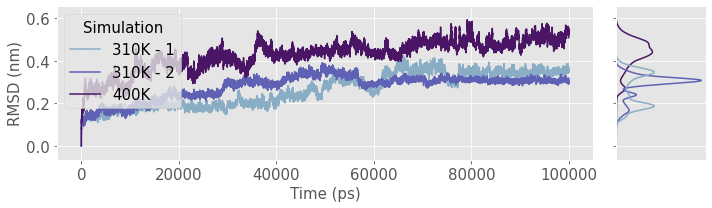

In [25]:
to_read = "rms.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15)
plt.savefig("Figures/RMS.png")

In [104]:
get_mean(df)

Simulation
310K - 1    0.263979
310K - 2    0.279671
400K        0.428676
Name: value, dtype: float64

# Distance

## Between A and rest

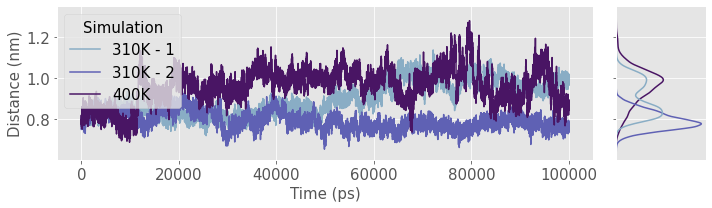

In [8]:
to_read = "distance_a_rest.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Distance (nm)")
plt.savefig("Figures/dist_a_rest.png")

In [301]:
df[df.Simulation == "400K"].head()

,Time,Simulation,value
40002,0.0,400K,0.796
40003,5.0,400K,0.774
40004,10.0,400K,0.780
40005,15.0,400K,0.806
40006,20.0,400K,0.819


In [70]:
get_mean(df)

Simulation
310K - 1    0.898730
310K - 2    0.791872
400K        0.959203
Name: value, dtype: float64

## Between A terminus

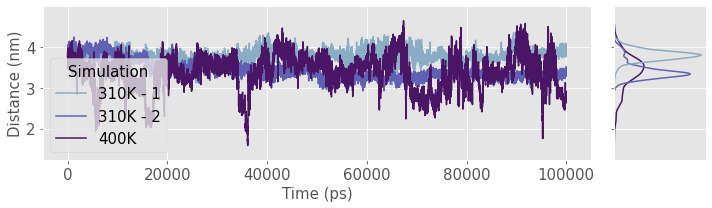

In [9]:
to_read = "distance_end.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Distance (nm)")
plt.savefig("Figures/dist_a_terminus.png")

In [72]:
get_mean(df)

Simulation
310K - 1    3.799934
310K - 2    3.430173
400K        3.383105
Name: value, dtype: float64

In [396]:
df.head()

,Time,Simulation,value
0,0.0,310K - 1,3.768
1,5.0,310K - 1,3.794
2,10.0,310K - 1,3.772
3,15.0,310K - 1,3.824
4,20.0,310K - 1,3.818


# Hydrogen bonds

## In the whole protein system

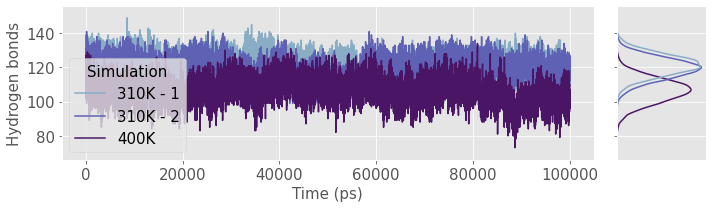

In [10]:
to_read = "hbonds_protein.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Hydrogen bonds")
plt.savefig("Figures/hb_sys.png")

In [74]:
get_mean(df)

Simulation
310K - 1    121.386381
310K - 2    119.101495
400K        106.400630
Name: value, dtype: float64

## between chain A and the rest

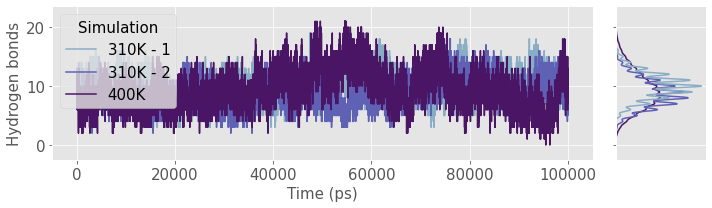

In [11]:
to_read = "hb_a_rest.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Hydrogen bonds")
plt.savefig("Figures/hb_a_rest.png")

In [76]:
get_mean(df)

Simulation
310K - 1    10.043498
310K - 2     8.765562
400K         9.342183
Name: value, dtype: float64

## In chain A

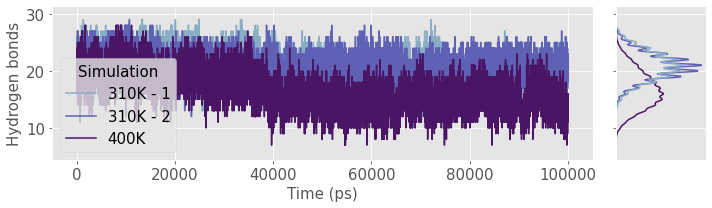

In [12]:
to_read = "hb_a_chain.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Hydrogen bonds")
plt.savefig("Figures/hb_a_chain.png")

In [386]:
df.head()

,Time,Simulation,value
0,0.0,310K - 1,22.0
1,5.0,310K - 1,21.0
2,10.0,310K - 1,21.0
3,15.0,310K - 1,24.0
4,20.0,310K - 1,26.0


In [388]:
get_mean(df)

Simulation
310K - 1    20.802760
310K - 2    20.742913
400K        16.757462
Name: value, dtype: float64

# Properties

## Potential energy

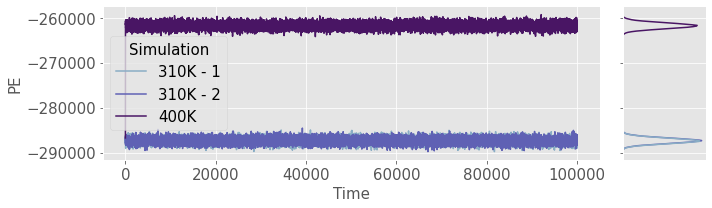

In [77]:
to_read = "potential.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "PE")
plt.savefig("Figures/PE.png")

In [78]:
get_mean(df)

Simulation
310K - 1   -287393.262343
310K - 2   -287359.995510
400K       -261784.285952
Name: value, dtype: float64

## Temperature

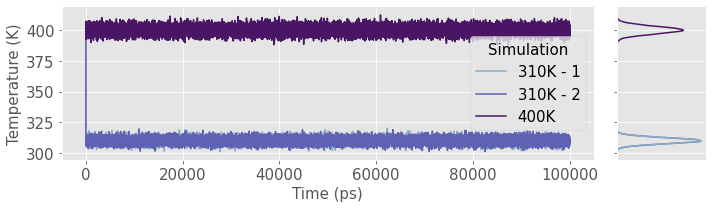

In [14]:
to_read = "temperature.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Temperature (K)")
plt.savefig("Figures/temperature.png")

In [80]:
get_mean(df)

Simulation
310K - 1    310.011419
310K - 2    310.017205
400K        400.005701
Name: value, dtype: float64

## Pressure

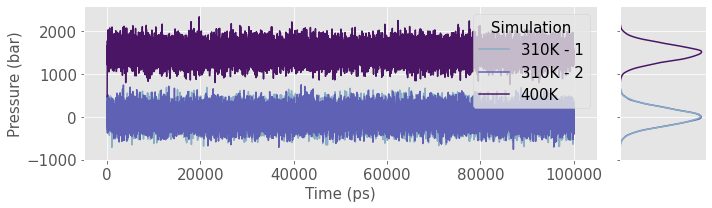

In [13]:
to_read = "pressure.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Pressure (bar)")
plt.savefig("Figures/pressure.png")

In [82]:
get_mean(df)

Simulation
310K - 1       0.454447
310K - 2       2.550137
400K        1500.272632
Name: value, dtype: float64

## Volume

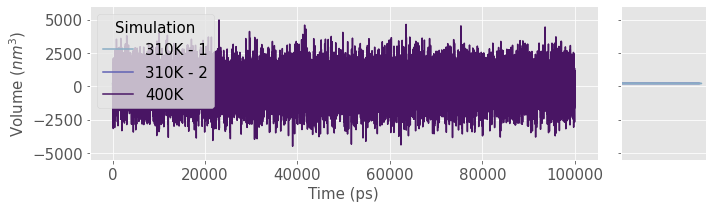

In [15]:
to_read = "volume.xvg"
df = get_df(to_read)
plot_joint(df, text_size = 15, ylabel = "Volume ($nm^3$)")
plt.savefig("Figures/volume.png")

In [93]:
get_mean(df)

Simulation
310K - 1    215.088178
310K - 2    215.144425
400K         17.927853
Name: value, dtype: float64

# Metadynamics

## Simulation 1 - terminus

    Step         x           y
12  20.0  1.283426 -280.935702
18  20.0  2.019030 -265.869625


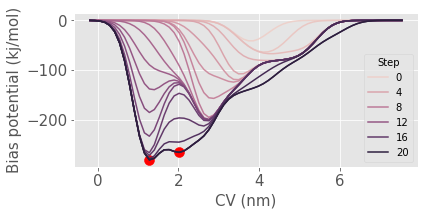

In [17]:
plot_fes(1, text_size = 15, with_minima = True)
plt.savefig("Figures/mtd-1.png")

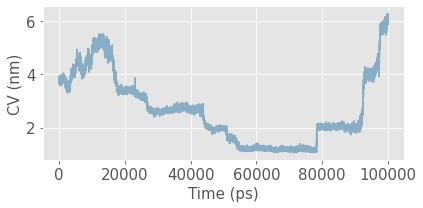

In [19]:
x, y = plot_cv(1)
plt.savefig("Figures/mtd-1-cv.png")

## Simulation 2 - chain A and rest of the complex

    Step         x           y
14  20.0  1.249148 -296.953683
69  20.0  8.042129   -6.101561
84  20.0  9.894760   -4.558934


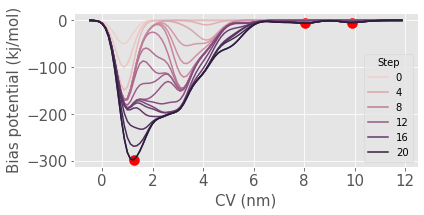

In [20]:
plot_fes(2, text_size = 15, with_minima = True)
plt.savefig("Figures/mtd-2.png")

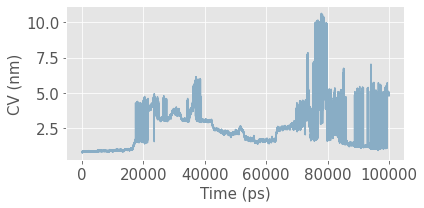

In [21]:
x, y = plot_cv(2)
plt.savefig("Figures/mtd-2-cv.png")

In [405]:
y[60000]

1.232122

## Simulation 3 - terminus

    Step         x           y
12  20.0  0.580522 -345.796995
20  20.0  1.566002 -254.851451
28  20.0  2.551481 -267.515176
58  20.0  6.247031 -182.966057


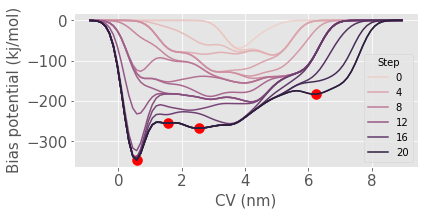

In [22]:
plot_fes(3, text_size = 15, with_minima = True)
plt.savefig("Figures/mtd-3.png")

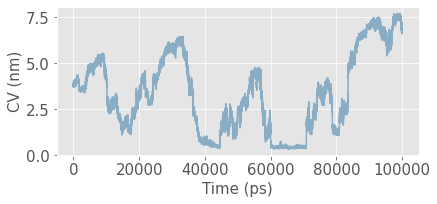

In [23]:
x, y = plot_cv(3)
plt.savefig("Figures/mtd-3-cv.png")

In [426]:
list_found = []
lower = 1.55
high = 1.57

for i in range(len(y)):
    if y[i] > lower and y [i] < high:
        list_found.append(i)
    i += 1

In [427]:
frame = list_found[1]

In [428]:
frame/100000*20000

2910.4